Load libraries and some utils funcs.

In [15]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tqdm
from collections import Counter
from random import choice, randint, random


"""
Main file for histogram equalization TSC Data
"""

def load_data(dir: str) -> tuple([dict, dict]):
    signs, ocurents = {}, {}
    for file in glob.glob(dir):
        tag = file.split('\\')[1][:-4]
        images = np.load(file)
        signs[tag] = images
        ocurents[tag] = images.shape[0]
    return signs, ocurents


def display_distribution(data, fig_size = (24,8)):
    """Displays the data distribution using a histogram

    Parameters
    ----------
    data  -- Count of every sign number

    fig_size -- size of the figure in the format of a tuple (height, width)
        default=(12, 4)
    """
    class_names = data.keys()
    print(class_names)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y =  range(len(data.keys()))
    ax.barh(y, data.values(), align='center')
    ax.set_yticks(y, labels=class_names)
    ax.set_xlim(0, 2000)
    ax.invert_yaxis()
    ax.set_xlabel('Nr of signs')
    ax.set_title('Number of images of each sign in dataset')

    plt.show()

  
def main(root_dir: str):
    signs, occurents = load_data(root_dir)
    print(signs["children"].shape)
    print(occurents)
    display_distribution(occurents)


Load signs display distribution

dict_keys(['bicycles-only', 'children', 'curve-left', 'curve-right', 'go-straight', 'junction-with-a-side-road-perpendicular-right', 'keep-left', 'keep-right', 'maximum-speed-limit-100', 'maximum-speed-limit-110', 'maximum-speed-limit-120', 'maximum-speed-limit-20', 'maximum-speed-limit-30', 'maximum-speed-limit-50', 'maximum-speed-limit-60', 'maximum-speed-limit-70', 'maximum-speed-limit-90', 'motorway', 'no-entry', 'no-heavy-goods-vehicles', 'no-left-turn', 'no-overtaking', 'no-parking', 'no-pedestrians', 'no-right-turn', 'no-stopping', 'no-u-turn', 'one-way-straight', 'other-sign', 'parking', 'pedestrians-crossing', 'priority-road', 'road-bump', 'road-closed-to-vehicles', 'roadworks', 'roundabout', 'shared-path-pedestrians-and-bicycles', 'slippery-road-surface', 'stop', 'tram-bus-stop', 'turn-left-left', 'turn-right', 'yield'])


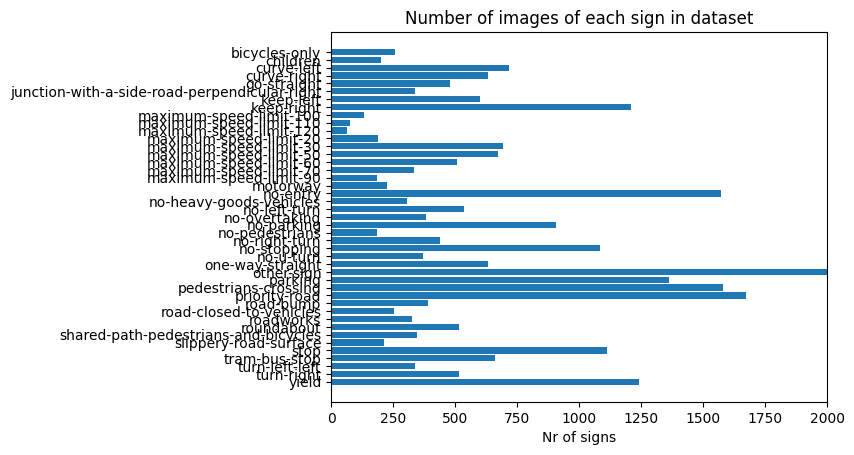

In [5]:
root_dir = "D:/ADEK/data/*"
signs, occurents = load_data(root_dir)
display_distribution(occurents)


Histogram equalization by adding augmented images

In [6]:
def fliph(img):
    """
    Flips the image horizontally (against the central vertical axis)

    Parameters
    ----------
    img - image to flip

    Returns
    -------
    Array corresponding to the input image, flipped horizontally.
    """
    img = np.fliplr(img)
    return img


def zoom(img, fac=.9):
    """
    Zooms into the center of an image by fac.

    Parameters
    ----------
    img - image to zoom
    fac - percantage of the image to zoom; 2-long list or tuple of floats, or float. If float, image is zoomed by fac in each direction.
    If list or tuple, zoomed by fac[0]*height vertically and fac[1]*width horizontally. In both cases floats
    should be between 0 and 1.
    
    Returns
    -------
    Array corresponding to the central (height*fac, width*fac) region of the image.
    """
    if not isinstance(fac, tuple) and not isinstance(fac, list):
        fac = (fac, fac)
    if fac[0] > 1:
        fac = (1, fac[1])
    if fac[1] > 1:
        fac = (fac[0], 1)
    if fac[0] <= 0:
        fac = (.5, fac[1])
    if fac[1] <= 0:
        fac = (fac[0], .5)
    h, w, _ = img.shape
    bounds_h = [int(h/2-h*(fac[0]/2.)), int(h/2+h*(fac[0]/2.))]
    bounds_w = [int(w/2-w*(fac[1]/2.)), int(w/2+w*(fac[1]/2.))]
    img = img[bounds_h[0]:bounds_h[1], bounds_w[0]:bounds_w[1], :]
    return img
    

def shiftdown(img, px=8):
    """
    Shifts the image down by px, with the gap at the top filled by stretching the topmost row of pixels.

    Parameteres
    ----------
    img - image to shift
    px - number of pixels to shift by

    Returns
    -------
    Array corresponding to the shifted image.
    """
    px = abs(px)
    img = np.roll(img, px, axis=0)
    if px > 0:
        for i in range(px):
            img[i, :, :] = img[px, :, :]
    return img


def shiftup(img, px=8):
    """
    Shifts the image up by px, with the gap at the bottom filled by stretching the bottom row of pixels.
    Parameteres
    ----------
    img - image to shift
    px - number of pixels to shift by
    Returns
    -------
    Array corresponding to the shifted image.
    """
    px = abs(px)
    img = np.roll(img, -px, axis=0)
    if px > 0:
        for i in range(px):
            img[img.shape[0] - i - 1, :, :] = img[img.shape[0] - px, :, :]
    return img


def shiftleft(img, px=6):
    """
    Shifts the image left by px, with the gap at the right filled by stretching the rightmost row of pixels.

    Parameteres
    ----------
    img - image to shift
    px - number of pixels to shift by

    Returns
    -------
    Array corresponding to the shifted image.
    """

    px = abs(px)
    img = np.roll(img, -px, axis=1)
    if px > 0:
        for i in range(px):
            img[:, img.shape[1] - i - 1, :] = img[:, img.shape[1] - px, :]
    return img


def shiftright(img, px=6):
    """
    Shifts the image right by px, with the gap at the left filled by stretching the leftmost row of pixels.
    Parameteres
    ----------
    img - image to shift
    px - number of pixels to shift by
    Returns
    -------
    Array corresponding to the shifted image.
    """
    px = abs(px)
    img = np.roll(img, px, axis=1)
    if px > 0:
        for i in range(px):
            img[:, i, :] = img[:, px, :]
    return img



def random_augment(img):
  """ 
  Choose a random type of image augmentation

  Paramteres
  ----------

  img - image to augment

  Returns
  -------

  Randomly augmented image

  """
  augs = [shiftdown, shiftup, shiftright, shiftleft, zoom]
  func = choice(augs)
  if func in [shiftup, shiftdown, shiftright, shiftleft]:
    px = randint(1, 5)
    return func(img, px)
  elif func == zoom:
    fac = (random()-0.5)/10. + 1. ## [0.95, 1.05)
    return func(img, fac)
  else:
    return func(img)
    


SIGN_SIZE = 3000
def augment_data(data, sign_counter): ## Deleted max_samples param
  """
  Apply data_augment function to the dataset, create new samples.
  For each class, create new augmented samples and add them until num_samples == 0.
  Concatenate original and augmented data.
  """

  for sign, samples_num in sign_counter.items():
      images = data[sign]
      if samples_num >= SIGN_SIZE:
          data[sign] = images[np.random.choice(np.arange(len(images)), size=min(len(images), SIGN_SIZE))]
          continue

      new_data_array = []
      signs_to_create = SIGN_SIZE - samples_num 
      print(f"Sign: {sign}, creating {signs_to_create} images")

      for _ in range(signs_to_create):
          image = choice(images)
          aug_image = random_augment(image)
          new_data_array.append(cv2.resize(aug_image, (64, 64)))

      np_new_data_array = np.stack(new_data_array, axis=0)
      data[sign] = np.concatenate((data[sign], np_new_data_array))
      sign_counter[sign] = SIGN_SIZE
      
  return data, sign_counter

aug_signs, aug_occurs = augment_data(signs, occurents)

Sign: bicycles-only, creating 2741 images
Sign: children, creating 2800 images
Sign: curve-left, creating 2282 images
Sign: curve-right, creating 2367 images
Sign: go-straight, creating 2521 images
Sign: junction-with-a-side-road-perpendicular-right, creating 2664 images
Sign: keep-left, creating 2402 images
Sign: keep-right, creating 1790 images
Sign: maximum-speed-limit-100, creating 2866 images
Sign: maximum-speed-limit-110, creating 2924 images
Sign: maximum-speed-limit-120, creating 2935 images
Sign: maximum-speed-limit-20, creating 2810 images
Sign: maximum-speed-limit-30, creating 2308 images
Sign: maximum-speed-limit-50, creating 2329 images
Sign: maximum-speed-limit-60, creating 2492 images
Sign: maximum-speed-limit-70, creating 2668 images
Sign: maximum-speed-limit-90, creating 2814 images
Sign: motorway, creating 2777 images
Sign: no-entry, creating 1430 images
Sign: no-heavy-goods-vehicles, creating 2696 images
Sign: no-left-turn, creating 2463 images
Sign: no-overtaking, c

Convert dataset to jpg images to load it easily with tensorflow keras later

In [19]:
def dict_to_jpg(signs):
    tags = signs.keys()
    dir = os.getcwd()
    folder_dir = os.path.join(dir, "augmented_data")
    os.mkdir(folder_dir)
    for sign, images in tqdm.tqdm(signs.items()):
        sign_dir = os.path.join(folder_dir, sign)
        os.mkdir(sign_dir) 
        for i in range(images.shape[0]):
            image_name=sign + str(i) + ".jpg"
            save_path=os.path.join(sign_dir, image_name)
            cv2.imwrite(save_path, images[i])
            

In [20]:
dict_to_jpg(aug_signs)

100%|██████████| 43/43 [01:06<00:00,  1.55s/it]
